## 🔍 Goal
- Use k-Means clustering on image pixels or image-level features to segment digits, then use those clusters as features for ML models like SVC, RF, etc.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
import time
import os

In [2]:
# load and preprocess data
def load_data(path='data/train.csv', threshold=0.95):
    df = pd.read_csv(path)
    X = df.drop('label', axis=1) / 255.0
    y = df['label']
    
    return train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [3]:
# Generate k-means

def generate_kmeans_features(X_train_full, k=20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    X_kmeans = kmeans.fit_transform(X_train_full)
    
    print(f"Generated KMeans features of shape: {X_kmeans.shape}")
    return X_kmeans, kmeans


In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

def plot_elbow_curve(X, max_k=20):
    distortions = []
    K = range(1, max_k + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center

    plt.figure(figsize=(8, 4))
    plt.plot(K, distortions, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Distortion)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def tune_svc_model(X_train, y_train):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(probability=True))
    ])

    param_dist = {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['linear', 'rbf'],
        'svc__gamma': ['scale', 'auto']
    }

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=8,
        scoring='accuracy',
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    
    print("🏆 Best Parameters:", search.best_params_)
    print("✅ Best CV Score:", search.best_score_)
    return search


In [5]:
# train and evaluate models

def train_and_evaluate_model(X_train, X_val, y_train, y_val, model, model_name):
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start
    
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)
    
    print(f"✅ {model_name} Accuracy: {acc:.4f}")
    
    return {
        "model_name": model_name,
        "accuracy": acc,
        "training_time": duration,
        "report": report,
        "model": model
    }

In [6]:
# plot segmented images

def plot_segmented_images(X_raw, labels, kmeans_model, indices=None, k=20):
    if indices is None:
        indices = np.random.choice(len(X_raw), 10, replace=False)
    
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    axs = axs.flatten()
    
    for i, idx in enumerate(indices):
        img = X_raw.iloc[idx].values.reshape(28, 28)
        cluster = kmeans_model.predict([X_raw.iloc[idx].values])[0]
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"Label: {labels.iloc[idx]}\nCluster: {cluster}")
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [9]:
# save model

import pickle

def save_model(model_dict, filename='model.pkl'):
    os.makedirs("outputs/models", exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump(model_dict, f)

In [8]:
def plot_model_comparison(results):
    names = [r["model_name"] for r in results]
    accs = [r["accuracy"] for r in results]
    times = [r["training_time"] for r in results]

    plt.figure(figsize=(10, 5))
    plt.barh(names, accs, color='skyblue')
    plt.xlabel("Accuracy")
    plt.title("📊 Model Accuracy Comparison")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.barh(names, times, color='salmon')
    plt.xlabel("Training Time (s)")
    plt.title("⏱️ Training Time Comparison")
    plt.show()


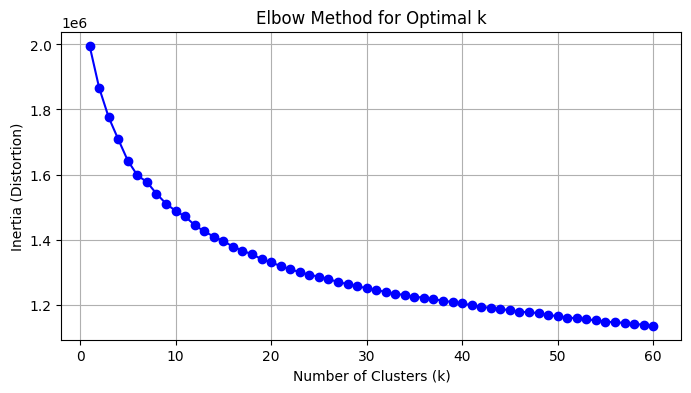

In [10]:
# Step 1: Load & preprocess
(X_train, X_val, y_train, y_val) = load_data(path='/kaggle/input/digit-recognizer/train.csv')

# Step 2: Elbow method to choose k
plot_elbow_curve(X_train, max_k=60)  # Visual inspection to pick optimal k

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generated KMeans features of shape: (42000, 10)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time= 1.1min
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time= 1.1min
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time= 1.1min
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time= 2.2min
[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time= 1.2min
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time= 2.2min
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time= 2.2min
[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time= 1.3min
[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time= 1.3min
[CV] END ......svc__C=100, svc__gamma=scale, svc__kernel=rbf; total time= 1.1min
[CV] END ......svc__C=100, svc__gamma=scale, svc__kernel=rbf; total time= 1.1min
[

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  w

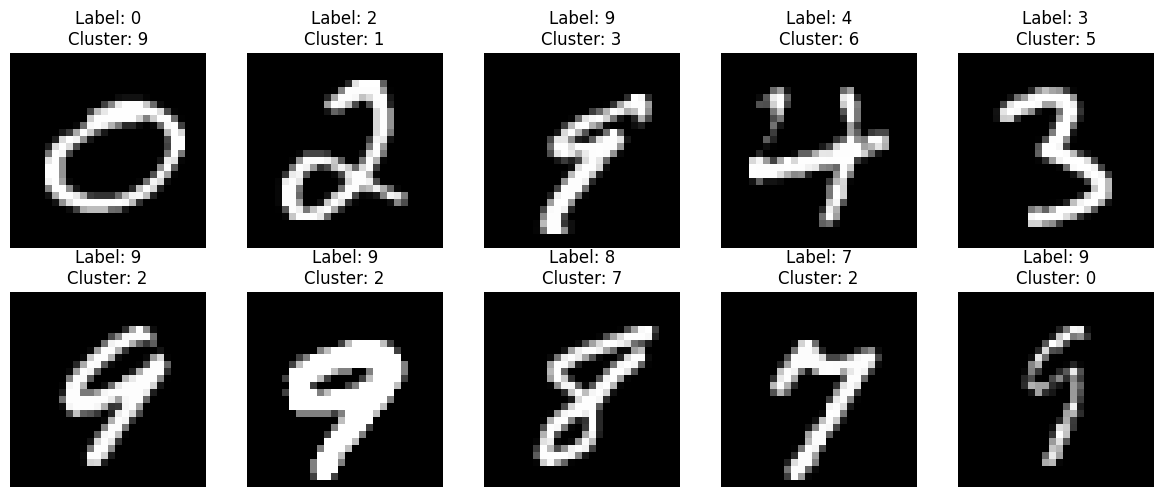

In [11]:
# Step 3: Generate cluster-based features (after selecting k, say k=10)
X_all = pd.concat([X_train, X_val])
X_kmeans, kmeans_model = generate_kmeans_features(X_all, k=10)

# Step 4: Split KMeans features
X_train_km = X_kmeans[:len(X_train)]
X_val_km = X_kmeans[len(X_train):]

# Step 5: Tune SVC with RandomizedSearchCV
best_svc_search = tune_svc_model(X_train_km, y_train)

# Step 6: Evaluate the tuned SVC
svc_result = train_and_evaluate_model(
    X_train_km, X_val_km,
    y_train, y_val,
    best_svc_search.best_estimator_,
    model_name='svc_kmeans_tuned'
)

# Step 7: Plot cluster-segmented images
plot_segmented_images(X_train.reset_index(drop=True), y_train.reset_index(drop=True), kmeans_model, k=15)

# Step 8: Save model
save_model(svc_result, 'outputs/models/svc_kmeans_tuned.pkl')

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

def tune_rf_model(X_train, y_train):
    rf = RandomForestClassifier(random_state=42)
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    search = RandomizedSearchCV(
        rf,
        param_distributions=param_dist,
        n_iter=5,
        scoring='accuracy',
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    print(f"Best RF Params: {search.best_params_}")
    return search


In [13]:
# Tune RF
best_rf_search = tune_rf_model(X_train_km, y_train)

# Evaluate RF
rf_result = train_and_evaluate_model(
    X_train_km, X_val_km,
    y_train, y_val,
    best_rf_search.best_estimator_,
    model_name='rf_kmeans_tuned'
)

# Save RF model
save_model(rf_result, 'outputs/models/rf_kmeans_tuned.pkl')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  33.1s
[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=  34.4s
[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=  34.9s
[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=  35.0s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=  16.4s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=  17.1s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  33.4s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=  16.5s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  33.5s
[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=  16.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  11.5s
[CV] END max_depth=10, min_samples_split=2, n_

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier

stack_model = StackingClassifier(
    estimators=[
        ('svc', best_svc_search.best_estimator_),
        ('rf', best_rf_search.best_estimator_)
    ],
    final_estimator=GradientBoostingClassifier(random_state=42),
    n_jobs=-1,
    cv=3,
    verbose=2
)

start = time.time()
stack_model.fit(X_train_km, y_train)
duration = time.time() - start

# Evaluate on validation set
y_pred = stack_model.predict(X_val_km)
acc = accuracy_score(y_val, y_pred)

print("📊 Stacking Validation Accuracy:", acc)
print("📄 Classification Report:\n", classification_report(y_val, y_pred))

# Save stack result
ensemble_result = {
    "model_name": "stack_svc_rf_kmeans",
    "training_time": duration,
    "accuracy": acc,
    "report": classification_report(y_val, y_pred, output_dict=True),
    "model": stack_model
}
save_model(ensemble_result, 'outputs/models/stack_svc_rf_kmeans.pkl')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


📊 Stacking Validation Accuracy: 0.9135714285714286
📄 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       413
           1       0.99      0.99      0.99       468
           2       0.93      0.94      0.94       418
           3       0.90      0.88      0.89       435
           4       0.84      0.86      0.85       407
           5       0.86      0.91      0.88       380
           6       0.94      0.98      0.96       414
           7       0.95      0.92      0.94       440
           8       0.90      0.87      0.88       406
           9       0.85      0.84      0.84       419

    accuracy                           0.91      4200
   macro avg       0.91      0.91      0.91      4200
weighted avg       0.91      0.91      0.91      4200



In [26]:
ensemble_result

{'model_name': 'stack_svc_rf_kmeans',
 'training_time': 394.5929636955261,
 'accuracy': 0.9135714285714286,
 'report': {'0': {'precision': 0.9537712895377128,
   'recall': 0.9491525423728814,
   'f1-score': 0.9514563106796117,
   'support': 413},
  '1': {'precision': 0.987152034261242,
   'recall': 0.9850427350427351,
   'f1-score': 0.9860962566844921,
   'support': 468},
  '2': {'precision': 0.933806146572104,
   'recall': 0.9449760765550239,
   'f1-score': 0.9393579072532698,
   'support': 418},
  '3': {'precision': 0.8988235294117647,
   'recall': 0.8781609195402299,
   'f1-score': 0.8883720930232558,
   'support': 435},
  '4': {'precision': 0.8429951690821256,
   'recall': 0.8574938574938575,
   'f1-score': 0.8501827040194884,
   'support': 407},
  '5': {'precision': 0.8621553884711779,
   'recall': 0.9052631578947369,
   'f1-score': 0.883183568677792,
   'support': 380},
  '6': {'precision': 0.9439252336448598,
   'recall': 0.9758454106280193,
   'f1-score': 0.9596199524940617,
  

In [16]:
import pandas as pd
import json
import os

def export_summary(results):
    # Make sure output folder exists
    os.makedirs("outputs", exist_ok=True)
    os.makedirs("outputs/reports", exist_ok=True)
    
    # Save each report
    for res in results:
        report_path = f"outputs/reports/classification_report_{res['model_name']}.json"
        with open(report_path, "w") as f:
            json.dump(res["report"], f, indent=4)
        save_model(res['model'], res['model_name'])
    
    # Extract summary into a DataFrame
    summary = pd.DataFrame([
        {
            "Model": res["model_name"],
            "Accuracy": res["accuracy"],
            "Training Time (s)": res["training_time"],
            "Report Path": f"outputs/reports/classification_report_{res['model_name']}.json",
            "Model Path":  f"outputs/models/{res['model_name']}.joblib"
        }
        for res in results
    ])
    
    # Export summary as CSV
    summary.to_csv("outputs/model_summary.csv", index=False)
    
    print("✅ Model summary exported to outputs/model_summary.csv")

In [22]:
results = [svc_result,rf_result,ensemble_result]
export_summary(results)

!zip -r outputs_file.zip /kaggle/working/outputs

✅ Model summary exported to outputs/model_summary.csv
  adding: kaggle/working/outputs/ (stored 0%)
  adding: kaggle/working/outputs/models/ (stored 0%)
  adding: kaggle/working/outputs/models/svc_kmeans_tuned.pkl (deflated 43%)
  adding: kaggle/working/outputs/models/rf_kmeans_tuned.pkl (deflated 87%)
  adding: kaggle/working/outputs/models/stack_svc_rf_kmeans.pkl (deflated 87%)
  adding: kaggle/working/outputs/model_summary.csv (deflated 59%)
  adding: kaggle/working/outputs/reports/ (stored 0%)
  adding: kaggle/working/outputs/reports/classification_report_stack_svc_rf_kmeans.json (deflated 74%)
  adding: kaggle/working/outputs/reports/classification_report_rf_kmeans_tuned.json (deflated 74%)
  adding: kaggle/working/outputs/reports/classification_report_svc_kmeans_tuned.json (deflated 75%)


/tmp/ipykernel_298/3356988762.py:25: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


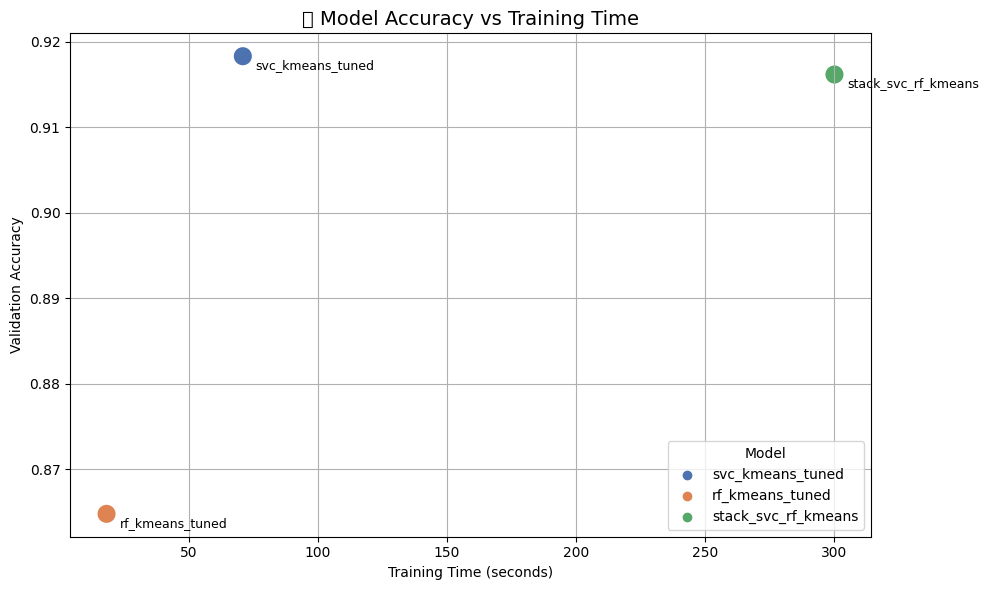

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


summary = pd.read_csv("/kaggle/working/outputs/model_summary.csv")

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=summary,
    x="Training Time (s)",
    y="Accuracy",
    hue="Model",
    s=200,
    palette="deep"
)

# Annotate model names
for i, row in summary.iterrows():
    plt.text(row["Training Time (s)"] + 5, row["Accuracy"] - 0.0015, row["Model"], fontsize=9)

plt.title("🔍 Model Accuracy vs Training Time", fontsize=14)
plt.xlabel("Training Time (seconds)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()